Dataset Shape: (200000, 21)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   architecture_type             200000 non-null  object 
 1   deployment_type               200000 non-null  object 
 2   communication_type            200000 non-null  object 
 3   num_services                  200000 non-null  int64  
 4   num_databases                 200000 non-null  int64  
 5   requests_per_second           200000 non-null  float64
 6   avg_payload_kb                200000 non-null  float64
 7   read_write_ratio              200000 non-null  float64
 8   peak_traffic_multiplier       200000 non-null  float64
 9   cpu_utilization_percent       200000 non-null  float64
 10  memory_utilization_percent    200000 non-null  float64
 11  network_latency_ms            200000 non-null  float64
 12  pack

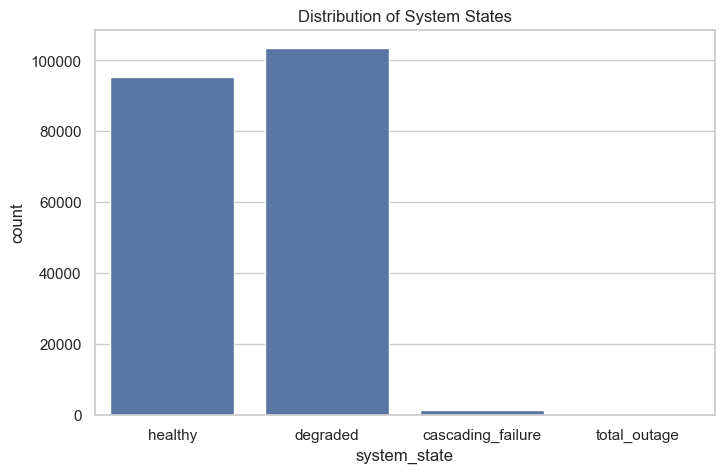

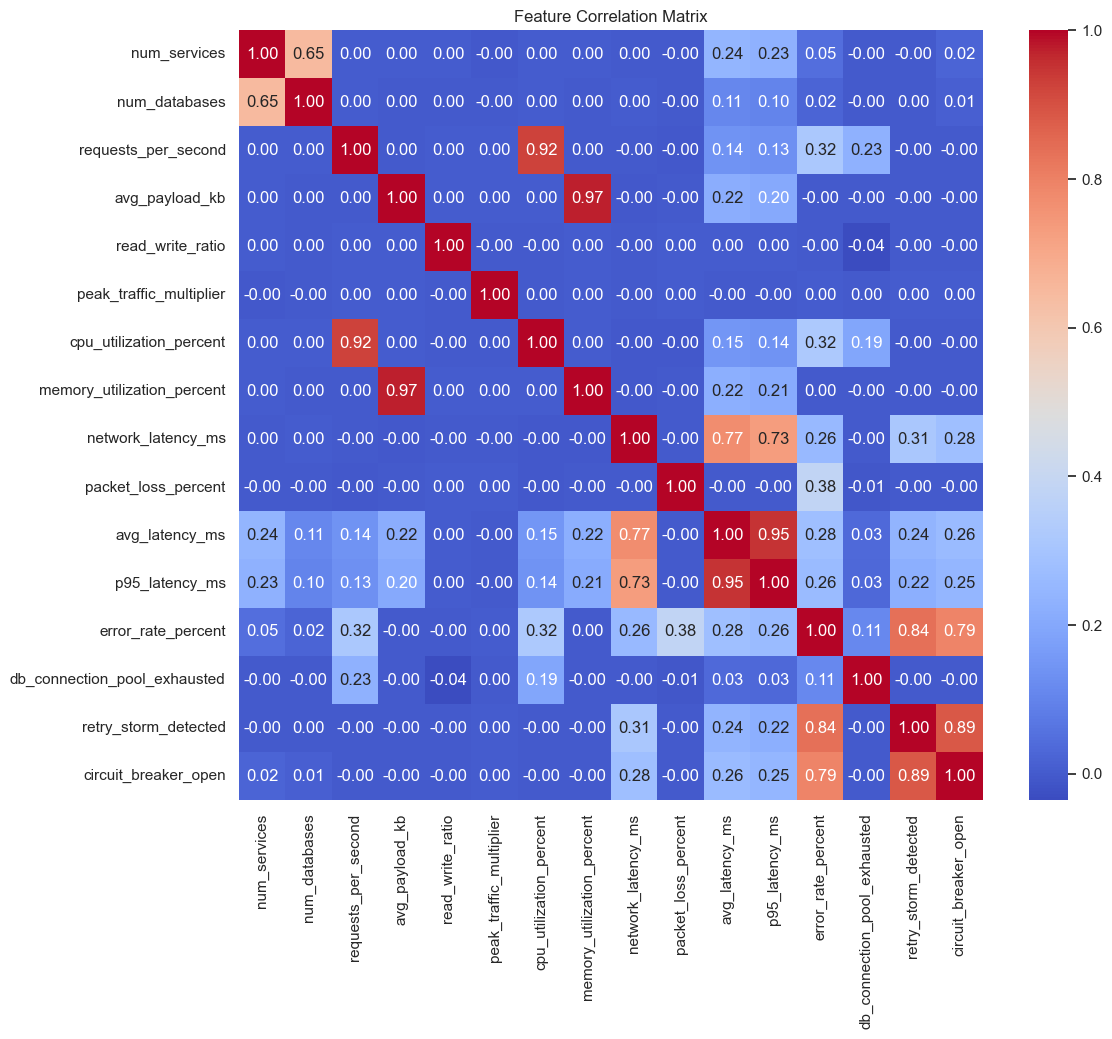

<Figure size 1000x600 with 0 Axes>

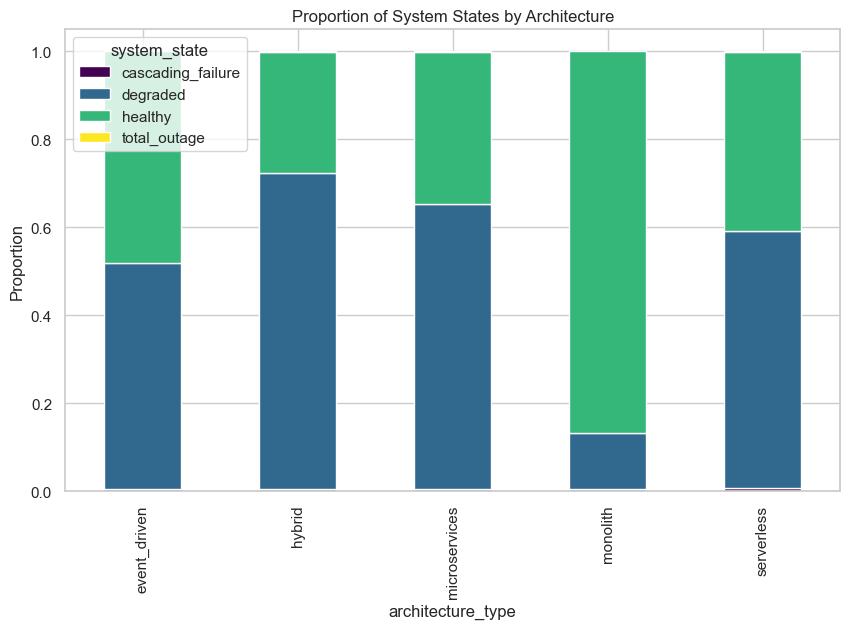

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# ==========================================
# 1. DATA LOADING & INSPECTION
# ==========================================
# Load the dataset
file_path = 'distributed_system_architecture_stress_dataset.csv'
df = pd.read_csv(file_path)

# Display basic info
print("Dataset Shape:", df.shape)
print("\nData Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

# ==========================================
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
# Set plot style
sns.set(style="whitegrid")

# A. System State Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='system_state', data=df, order=['healthy', 'degraded', 'cascading_failure', 'total_outage'])
plt.title('Distribution of System States')
plt.savefig('system_state_distribution_user.png') # Changed to savefig

# B. Correlation Heatmap (Numerical Features)
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_heatmap_user.png') # Changed to savefig

# C. Architecture vs System State
plt.figure(figsize=(10, 6))
# Using crosstab directly might be tricky with plot if not assigned
ct = pd.crosstab(df['architecture_type'], df['system_state'], normalize='index')
ct.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10,6))
plt.title('Proportion of System States by Architecture')
plt.ylabel('Proportion')
plt.savefig('architecture_vs_state_user.png') # Changed to savefig

# ==========================================
# 3. DATA PREPROCESSING
# ==========================================
# Separate features and target
X = df.drop(['system_state', 'root_cause'], axis=1)
y = df['system_state']

# Identify column types
categorical_features = ['architecture_type', 'deployment_type', 'communication_type']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create Preprocessing Pipeline
# - Numerical: Standard Scaling
# - Categorical: One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Encode Target Variable (healthy, degraded, etc. -> 0, 1, 2, 3)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Split Data (Stratified to handle class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# ==========================================
# 4. MODEL DEVELOPMENT & EVALUATION
# ==========================================
def train_and_evaluate(model, model_name):
    """
    Trains a model using a pipeline and prints evaluation metrics.
    """
    # Create pipeline with preprocessor and classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    # Train model
    print(f"\nTraining {model_name}...")
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"--- {model_name} Results ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
    
    return pipeline

# Initialize Models with class_weight='balanced' to handle imbalance
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    "Linear SVM": LinearSVC(class_weight='balanced', random_state=42, dual=False)
}

# Run Training Loop
trained_models = {}
for name, model in models.items():
    trained_models[name] = train_and_evaluate(model, name)

# ==========================================
# 5. ROOT CAUSE ANALYSIS & FEATURE IMPORTANCE
# ==========================================
# Extract Feature Importance from Random Forest
rf_pipeline = trained_models["Random Forest"]
rf_model = rf_pipeline.named_steps['classifier']
preprocessor_step = rf_pipeline.named_steps['preprocessor']

# Get feature names after OneHotEncoding
cat_feature_names = preprocessor_step.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, cat_feature_names])

# Get importances and sort
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\n--- Top 10 Features Driving System Failures ---")
for f in range(10):
    print(f"{f+1}. {all_feature_names[indices[f]]} ({importances[indices[f]]:.4f})")